In [1]:
#shenanigans so python finds weak_sauce module 
import sys
sys.path.append('/u/ki/mbaumer/random_pixel_size/weak_sauce/code')
print sys.path

['', '/u/ki/mbaumer/local/pappy', '/afs/slac.stanford.edu/u/ki/mbaumer/random_pixel_size/weak_sauce/notebooks', '/u/ki/mbaumer/local/lib/python2.7/site-packages', '/u/ki/mbaumer/anaconda/lib/python27.zip', '/u/ki/mbaumer/anaconda/lib/python2.7', '/u/ki/mbaumer/anaconda/lib/python2.7/plat-linux2', '/u/ki/mbaumer/anaconda/lib/python2.7/lib-tk', '/u/ki/mbaumer/anaconda/lib/python2.7/lib-old', '/u/ki/mbaumer/anaconda/lib/python2.7/lib-dynload', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/cryptography-0.9.1-py2.7-linux-x86_64.egg', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/setuptools-17.1.1-py2.7.egg', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/IPython/extensions', '/u/ki/mbaumer/random_pixel_size/weak_sauce/code']


In [3]:
%matplotlib inline
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source
from weak_sauce.movers import UniformIlluminationMover, FixedIlluminationMover
from weak_sauce.fit_flat import FlatFitter

def gauss(centroids, mu=np.array([0, 0]), sigma=np.array([1., 1.])):
    return np.exp(-0.5 * np.sum(np.square((centroids - mu) / sigma), axis=2)) / \
           (2 * np.pi * np.prod(sigma))
    
import galsim

(<matplotlib.figure.Figure at 0x7f580f7bf590>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f580fa81350>)

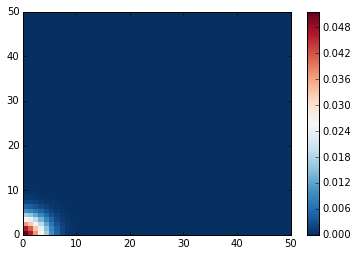

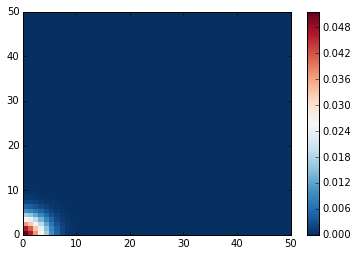

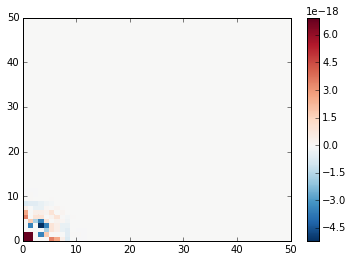

In [8]:
src1 = Source(num_x=51,flux_func=gauss,sigma=3)
test_galsim = galsim.Gaussian(sigma=3,flux=3)
src2 = Source(num_x=51,flux_func=test_galsim)
src1.plot_pixel_grid()
src2.plot_pixel_grid()
src1.plot(src1.fluxes-src2.fluxes)

So the galsim gaussian object (with flux=3) matches the hand-coded gaussian flux_func to 1 part in 10^17, so we're good!